### Marcel Projections

In [1]:
import pandas as pd
from pathlib import Path
import statsmodels.formula.api as sm
import numpy as np

In [2]:
def main(metric):
    interim = '../data/interim'
    br = pd.read_pickle(Path(interim) / 'batting_records.pkl')
    gl = pd.read_pickle(Path(interim) / 'game_logs.pkl')
    events = pd.read_pickle(Path(interim) / 'events.pkl')
    people = pd.read_pickle(Path(interim) / 'people.pkl')
    
    br = br.loc[:, [metric, 'PA', 'G']]

    br = fill_gaps(br)

    merged = merge_data(br, people)
    merged[metric] = merged[metric].astype('int')
    merged['PA'] = merged['PA'].astype('int')
    merged['G'] = merged['G'].astype('int')
    
    lr = gen_league(events, metric)
    merged['pred_' + metric + 'PPA'], merged['pred_PA'], merged['pred_' + metric] = marcel(merged, lr, metric)
    
    merged['prev_G'] = merged.groupby('BAT_ID')['G'].shift(1).fillna(0)
    merged = merged.loc[merged.PA != 0]
    return merged

def fill_gaps(br):
    br = br.reset_index()
    br['first_year'] = br.groupby('BAT_ID')['year'].transform("min")
    br['last_year'] = br.groupby('BAT_ID')['year'].transform("max")

    br = br.set_index(['BAT_ID', 'year'])
    br = br.unstack(fill_value=0).stack(dropna=False)
    br['first_year'] = br.groupby('BAT_ID')['first_year'].transform("max")
    br['last_year'] = br.groupby('BAT_ID')['last_year'].transform("max")
    
    br = br.loc[(br.index.get_level_values('year') <= br['last_year']) & 
                  (br.index.get_level_values('year') >= br['first_year'])]
    del br['first_year']
    del br['last_year']
    
    return br


def merge_data(br, people):
    br = br.reset_index()
    
    merged = pd.merge(
        br, 
        people[['PlayerID', 'birthYear']], 
        left_on = ['BAT_ID'], 
        right_on=['PlayerID'], 
        how='left'
    )
    
    merged = merged.set_index(['BAT_ID', 'year']).sort_values(['BAT_ID', 'year'])
    
    merged['Age'] = merged.index.get_level_values('year') - merged['birthYear']
    del merged['birthYear']
    
    merged = merged.sort_values(['BAT_ID', 'year'])

    return merged

def marcel(df, lr, metric):    
    w = [5, 4, 3]
    
    pred_PA = est_PA(df)
    pred_naive_rate = est_naive_rate(df, w, metric)
    
    league_adj_rate = reg_to_league_mean(df, pred_naive_rate, w, lr)
    pred_rate = adjust_age(df['Age'], league_adj_rate)
    
    pred_amt = (pred_PA * pred_rate).astype('float')
    
    return pred_rate, pred_PA, pred_amt

def gen_league(events, metric):
    League = events[events.BAT_FLD_CD != 1].groupby('year')[[metric, 'PA']].sum()
    League.columns = ['League_count', 'League_PA']

    League['League_rate'] = League['League_count'] / League['League_PA']
    League['L1_League_rate'] = League['League_rate'].shift(1)
    League['L2_League_rate'] = League['League_rate'].shift(2)
    League['L3_League_rate'] = League['League_rate'].shift(3)
    League = League.sort_values('year')
    
    return League

def est_PA(df):
    group = df.groupby('BAT_ID')['PA']
    L1 = group.shift(1).fillna(0)
    L2 = group.shift(2).fillna(0)

    pred_PA = (.5 * L1 + .1 * L2 + 200).astype('float')
    
    return pred_PA

def est_naive_rate(df, w, metric):
    group = df.groupby('BAT_ID')[[metric, 'PA']]
    L1 = group.shift(1).fillna(0)
    L2 = group.shift(2).fillna(0)
    L3 = group.shift(3).fillna(0)
    
    sum_metric = w[0]*L1[metric] + w[1]*L2[metric] + w[2]*L3[metric]
    sum_PA = w[0]*L1['PA'] + w[1]*L2['PA'] + w[2]*L3['PA']
    naive_rate = sum_metric / sum_PA
    
    return naive_rate

def reg_to_league_mean(df, naive_rate, w, lr):
    temp = pd.merge(df.reset_index(), lr, on='year', how='left')
    temp = temp.set_index(['BAT_ID', 'year'])
    
    group = temp.groupby('BAT_ID')[['PA']]
    temp['L1_PA'] = group.shift(1).fillna(0)
    temp['L2_PA'] = group.shift(2).fillna(0)
    temp['L3_PA'] = group.shift(3).fillna(0)
    
    League_sum = (
        w[0]*temp['L1_League_rate'] + 
        w[1]*temp['L2_League_rate'] +
        w[2]*temp['L3_League_rate']
    )
    
    League_PA_weighted_sum = (
        w[0]*temp['L1_League_rate']*temp['L1_PA'] + 
        w[1]*temp['L2_League_rate']*temp['L2_PA'] +
        w[2]*temp['L3_League_rate']*temp['L3_PA']
    )
    sum_PA = w[0]*temp['L1_PA'] + w[1]*temp['L2_PA'] + w[2]*temp['L3_PA']
    
    League_mean_rate = League_PA_weighted_sum / sum_PA
    League_mean_rate = League_mean_rate.where(sum_PA > 0, League_sum / sum(w))

    reliability = sum_PA / (1200 + sum_PA)
    
    adj_rate = League_mean_rate * (1 - reliability) + naive_rate * reliability
    adj_rate = adj_rate.where(sum_PA > 0, League_sum / sum(w))
    
    return adj_rate

def adjust_age(Age, adj_rate):
    age_adj = np.where(
        Age <= 29, 
        1 + (29 - Age)* .006,
        1 + (29 - Age)* .003,
    )
    pred_rate = (adj_rate * age_adj).astype('float')
    
    return pred_rate

In [14]:
df = main('H')
df['HPPA'] = df['H'] / df['PA']

In [15]:
df[df.index.get_level_values('BAT_ID') == 'harpb003']

H   PA    G  PlayerID   Age  pred_HPPA  pred_PA      pred_H  \
BAT_ID   year                                                                  
harpb003 2012  144  597  138  harpb003  20.0   0.245972    200.0   49.194449   
         2013  116  497  118  harpb003  21.0   0.250107    498.5  124.678303   
         2014   96  395  100  harpb003  22.0   0.246060    508.2  125.047694   
         2015  172  654  153  harpb003  23.0   0.246309    447.2  110.149473   
         2016  123  627  147  harpb003  24.0   0.255419    566.5  144.694736   
         2017  134  492  111  harpb003  25.0   0.235302    578.9  136.216252   
         2018  137  695  159  harpb003  26.0   0.244992    508.7  124.627289   
         2019  149  682  157  harpb003  27.0   0.221340    596.7  132.073487   
         2020   51  244   58  harpb003  28.0   0.223349    610.5  136.354370   

               prev_G      HPPA  
BAT_ID   year                    
harpb003 2012     0.0  0.241206  
         2013   138.0  0.233400  
         2014   118.0  0.243038  
         2015   100.0  0.262997  
         2016   153.0  0.196172  
         2017   147.0  0.272358  
         2018   111.0  0.197122  
         2019   159.0  0.218475  
         2020   157.0  0.209016

### Regression Check

In [16]:
limited = df[(df.G >= 50)  & (df.prev_G >= 50)]
result = sm.ols(formula="HPPA ~ pred_HPPA", data=limited).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   HPPA   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     8886.
Date:                Tue, 23 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:01:15   Log-Likelihood:                 46198.
No. Observations:               21188   AIC:                        -9.239e+04
Df Residuals:                   21186   BIC:                        -9.238e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0285      0.002     12.889      0.0

In [17]:
def adjust_plot(plt):
    plt.xaxis.grid(False)
    plt.yaxis.grid(True, linestyle='dashed', color='lightgrey')
    plt.set_axisbelow(True)
    plt.xaxis.set_ticks_position('none') 
    plt.yaxis.set_ticks_position('none') 

    plt.spines['left'].set_visible(False)
    plt.spines['right'].set_visible(False)
    plt.spines['top'].set_visible(False)

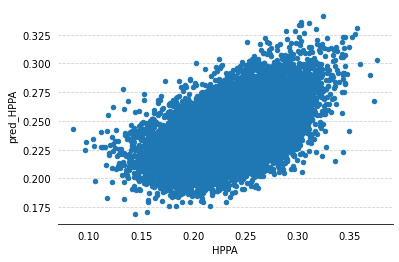

In [18]:
plt = limited.plot.scatter(x='HPPA', y='pred_HPPA')
adjust_plot(plt)

# Experiment

In [28]:
test = df
test['L1_H'] = test.groupby('BAT_ID')['H'].shift(1).fillna(0)
test['L2_H'] = test.groupby('BAT_ID')['H'].shift(2).fillna(0)
test['L3_H'] = test.groupby('BAT_ID')['H'].shift(3).fillna(0)

test['L1_PA'] = test.groupby('BAT_ID')['PA'].shift(1).fillna(0)
test['L2_PA'] = test.groupby('BAT_ID')['PA'].shift(2).fillna(0)
test['L3_PA'] = test.groupby('BAT_ID')['PA'].shift(3).fillna(0)

test['L1_sum_PA'] = test['L1_PA'] + test['L2_PA'] + test['L3_PA']

test['L1_adj_H'] = test['L1_H'] / test['L1_sum_PA']
test['L2_adj_H'] = test['L2_H'] / test['L1_sum_PA']
test['L3_adj_H'] = test['L3_H'] / test['L1_sum_PA']

test['dif'] = test['HPPA'] - test['L1_adj_H']
results = sm.ols(formula="dif ~ L2_adj_H + L3_adj_H -1", data=test).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    dif   R-squared (uncentered):                   0.507
Model:                            OLS   Adj. R-squared (uncentered):              0.507
Method:                 Least Squares   F-statistic:                          2.858e+04
Date:                Tue, 23 Mar 2021   Prob (F-statistic):                        0.00
Time:                        17:21:01   Log-Likelihood:                          44395.
No. Observations:               55556   AIC:                                 -8.879e+04
Df Residuals:                   55554   BIC:                                 -8.877e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------